In [66]:
import re
import pandas as pd
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
data_path = Path('../data/')
search_res_html = (data_path / 'nidb_nimh_search_2018_11_07.htm').read_text()

In [3]:
ipid_pat = re.compile(r'\?ipid=([0-9]*)')

In [4]:
ipids = pd.unique(re.findall(ipid_pat,search_res_html))

In [5]:
def get_pj_info(ipid):
    url = f'https://intramural.nih.gov/search/searchview.taf?ipid={ipid}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    headings = [dd.text for dd in soup.findAll('div', attrs={'class':'headings'})]
    headings.append('pj_num')
    data = [dd.text for dd in soup.findAll('div', attrs={'class':'data'})]
    data.append(soup.findAll('div', attrs={'class':'contentlabel'})[0].text)
    return (ipid, headings, data)

In [6]:
pj_info = [get_pj_info(ipid) for ipid in ipids]

In [7]:
pj_clean = []
for ipid, headings, data in pj_info:
    # clean up headings
    for hi,head in enumerate(headings):
        #Pubs generated
        if 'Lab Staff and Collaborators' in head:
            headings[hi] = 'Lab Staff and Collaborators'
        if 'Extramural Collaborator' in head:
            headings[hi] = 'Extramural Collaborators'
        if 'Publications Generated' in head:
            if 'See Project Bibliography' in head:
                more_refs = True
            headings[hi] = 'Publications Generated'
        else:
            headings[hi] = headings[hi].strip()
    res = pd.DataFrame.from_dict([{h:d for h,d in zip(headings,data)}])
    res['ipid'] = ipid
    res['more_references'] = more_refs
    pj_clean.append(res)

In [8]:
pj_df = pd.concat(pj_clean, sort=False).reset_index(drop=True)

In [9]:
pj_df['Research Organization'] = pj_df['Research Organization'].str.strip()

In [10]:
pj_df['PI'] = pj_df['Principal Investigator'].str.strip().str.split('\n').str[0]
pj_df['PI'] = pj_df['PI'].fillna(pj_df['Lead Investigator'].str.strip())

In [11]:
fund_df = pd.read_csv('../data/SR_13Nov2018_120853_MR_167922.csv', skiprows=4)
fund_df['short_pj_num'] = fund_df['Project Number'].str.split('MH').str[-1].str.split('-').str[0]
pj_df['short_pj_num'] = pj_df.pj_num.str.split('-').str[0].str.strip('MH')
pj_df = pj_df.merge(fund_df.loc[(fund_df.FY == 2017) & (fund_df['Funding IC'] == 'NIMH'), 
                        ['short_pj_num', 'FY Total Cost by IC']],
            how='left',
            on='short_pj_num')

In [12]:
import nltk

In [13]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [14]:
stopwords.extend(["'s",
                  "et",
                  "et al",
                  "et al.",
                  "al",
                  "al.",
                  "and/or",
                  "e.g.",
                  "i.e.",
                  "dr."])

In [15]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [16]:
pj_df['pj_text'] = pj_df['Goals and Objectives'] + pj_df['Summary']

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [18]:
tfidf_matrix = tfidf_vectorizer.fit_transform(pj_df['pj_text'].values)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dr', 'dure', 'e.g', 'i.e', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


In [19]:
tfidf_matrix.shape

(91, 814)

In [20]:
terms = tfidf_vectorizer.get_feature_names()

In [21]:
terms

['abil',
 'abl',
 'abnorm',
 'abov',
 'accompani',
 'accomplish',
 'account',
 'accur',
 'achiev',
 'acid',
 'acquir',
 'acquisit',
 'across',
 'act',
 'action',
 'activ',
 'ad',
 'adapt',
 'addit',
 'address',
 'administr',
 'adolesc',
 'adult',
 'advanc',
 'advantag',
 'affect',
 'age',
 'agent',
 'aim',
 'allow',
 'allow us',
 'along',
 'also provid',
 'alter',
 'although',
 'among',
 'amygdala',
 'analys',
 'analysi',
 'analyz',
 'anatom',
 'ani',
 'anim',
 'annual',
 'anoth',
 'anterior',
 'anticip',
 'anxieti',
 'anxieti disord',
 'appear',
 'appli',
 'applic',
 'approach',
 'appropri',
 'approxim',
 'architectur',
 'area',
 'aris',
 'around',
 'ask',
 'aspect',
 'assess',
 'assist',
 'associ',
 'attempt',
 'attent',
 'autism',
 'avail',
 'averag',
 'base',
 'basi',
 'basic',
 'becaus',
 'becom',
 'befor',
 'begin',
 'behavior',
 'best',
 'better',
 'better understand',
 'bias',
 'biolog',
 'biomark',
 'bipolar',
 'bipolar disord',
 'blood',
 'bodi',
 'brain activ',
 'brain funct

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

In [186]:
tfidf_matrix

<91x103518 sparse matrix of type '<class 'numpy.float64'>'
	with 132331 stored elements in Compressed Sparse Row format>

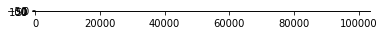

In [187]:
plt.imshow(tfidf_matrix.todense())

In [340]:
from sklearn.cluster import KMeans, ward_tree
from sklearn.metrics import silhouette_samples, silhouette_score

num_clusters = 4

km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.22 s, sys: 14 ms, total: 2.23 s
Wall time: 661 ms


CPU times: user 359 ms, sys: 9.54 ms, total: 368 ms
Wall time: 281 ms


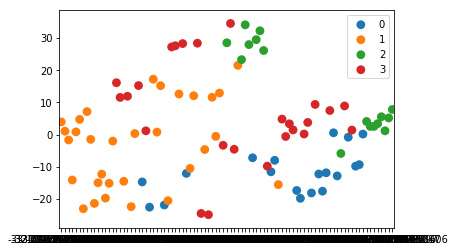

In [347]:
from sklearn.manifold import TSNE
mds = TSNE(perplexity=5, init='pca', learning_rate=10, metric='cosine')
%time pj_mds = mds.fit_transform(tfidf_matrix.toarray())
sns.pointplot(pj_mds[:,0], pj_mds[:,1], hue=clusters, join=False)

In [189]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [301]:
pj_df['cluster'] = clusters
pj_df['cluster'].value_counts()

1    31
2    27
0    25
3     8
Name: cluster, dtype: int64

-1    91
Name: cluster, dtype: int64

In [302]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_budgets = pj_df.groupby('cluster')[['FY Total Cost by IC']].sum().values

for i in range(num_clusters):
    cb = int(cluster_budgets[i][0])
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print(f"Cluster {i:d} total 2017 budget: ${cb:,d}")
    print() #add whitespace
    
    print("Cluster %d Section:" % i, end='')
    for title in pj_df.loc[pj_df['cluster']==i, 'Research Organization'].tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print()
print()


Top terms per cluster:

Cluster 0 words: research, nimh, clinic, program, train, irp, radiotrac, nih, provid, ocd,
Cluster 0 total 2017 budget: $55,324,538

Cluster 0 Section: Section on Neural Gene Expression, NIMH,
 Section on Behavioral Pediatrics, NIMH,
 Section on PET Radiopharmaceutical Sciences, NIMH,
 Section on Synapse Development Plasticity, NIMH,
 Unit on Neural Circuits and Adaptive Behaviors, NIMH,
 Office of the Director, NIMH,
 Office of the Clinical Director, NIMH,
 Unit on the Neurobiology of Affective Memory, NIMH,
 Unit on Non-invasive Neuromodulation, NIMH,
 Functional MRI Core, NIMH,
 Scientific and Statistical Computing Core, NIMH,
 Magnetoencephalography Core, NIMH,
 Neurophysiology Imaging Core, NIMH,
 Section on Instrumentation, NIMH,
 Rodent Behavioral Core, NIMH,
 Functional MRI Core, NIMH,
 Office of the Clinical Director, NIMH,
 Systems Neuroscience Imaging Resource, NIMH,
 Functional MRI Core, NIMH,
 Office of the Clinical Director, NIMH,
 Office of the Cl

In [285]:
cluster_budgets

array([[1.44031402e+08]])

In [67]:
pd.unique(pj_df['Report Title'])

array(['Dysregulation of Protein Synthesis in Fragile X Syndrome and Other Developmental Disorders\n\n\n',
       'Studies of Central Nervous System Functional Anatomy\n\n\n',
       'Neural Coding of Visual Stimuli\n\n\n',
       'Functional Anatomy of Perceptual and Attentional Systems in the Primate Brain\n\n\n',
       'Chemical Coding of Neurotransmission\n\n\n',
       'Functional Organization of the Cerebral Cortex and Basal Ganglia\n\n\n',
       'Roles of Oxytocin and Vasopressin in Brain\n\n\n',
       'Psychobiology and Treatment of Perimenopausal Mood Disorders\n\n\n',
       'The Neural Foundations for Memory  and Social Cognition In The Human Brain\n\n\n',
       'Neural Mechanisms of Motivation and Reward\n\n\n',
       'Imaging of Neuropsychiatric Disorders with Developmental and Genetic Mechanisms\n\n\n',
       'Evaluation and Treatment of Obsessive Compulsive and Related Disorders\n\n\n',
       'Neuroimaging of Brain Circuits and Molecular Mechanisms in Normal Cogni

In [72]:
 pj_df['label'] =  pj_df['PI'].str.split(';').str[0] + ', '  + pj_df['Research Organization'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '')
 pj_df['longlabel'] = pj_df['PI'].str.split(';').str[0] + ', '  + pj_df['Research Organization'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '') + ', ' +  pj_df['Report Title'].str.strip()

## Hierarchical clusters

In [63]:
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

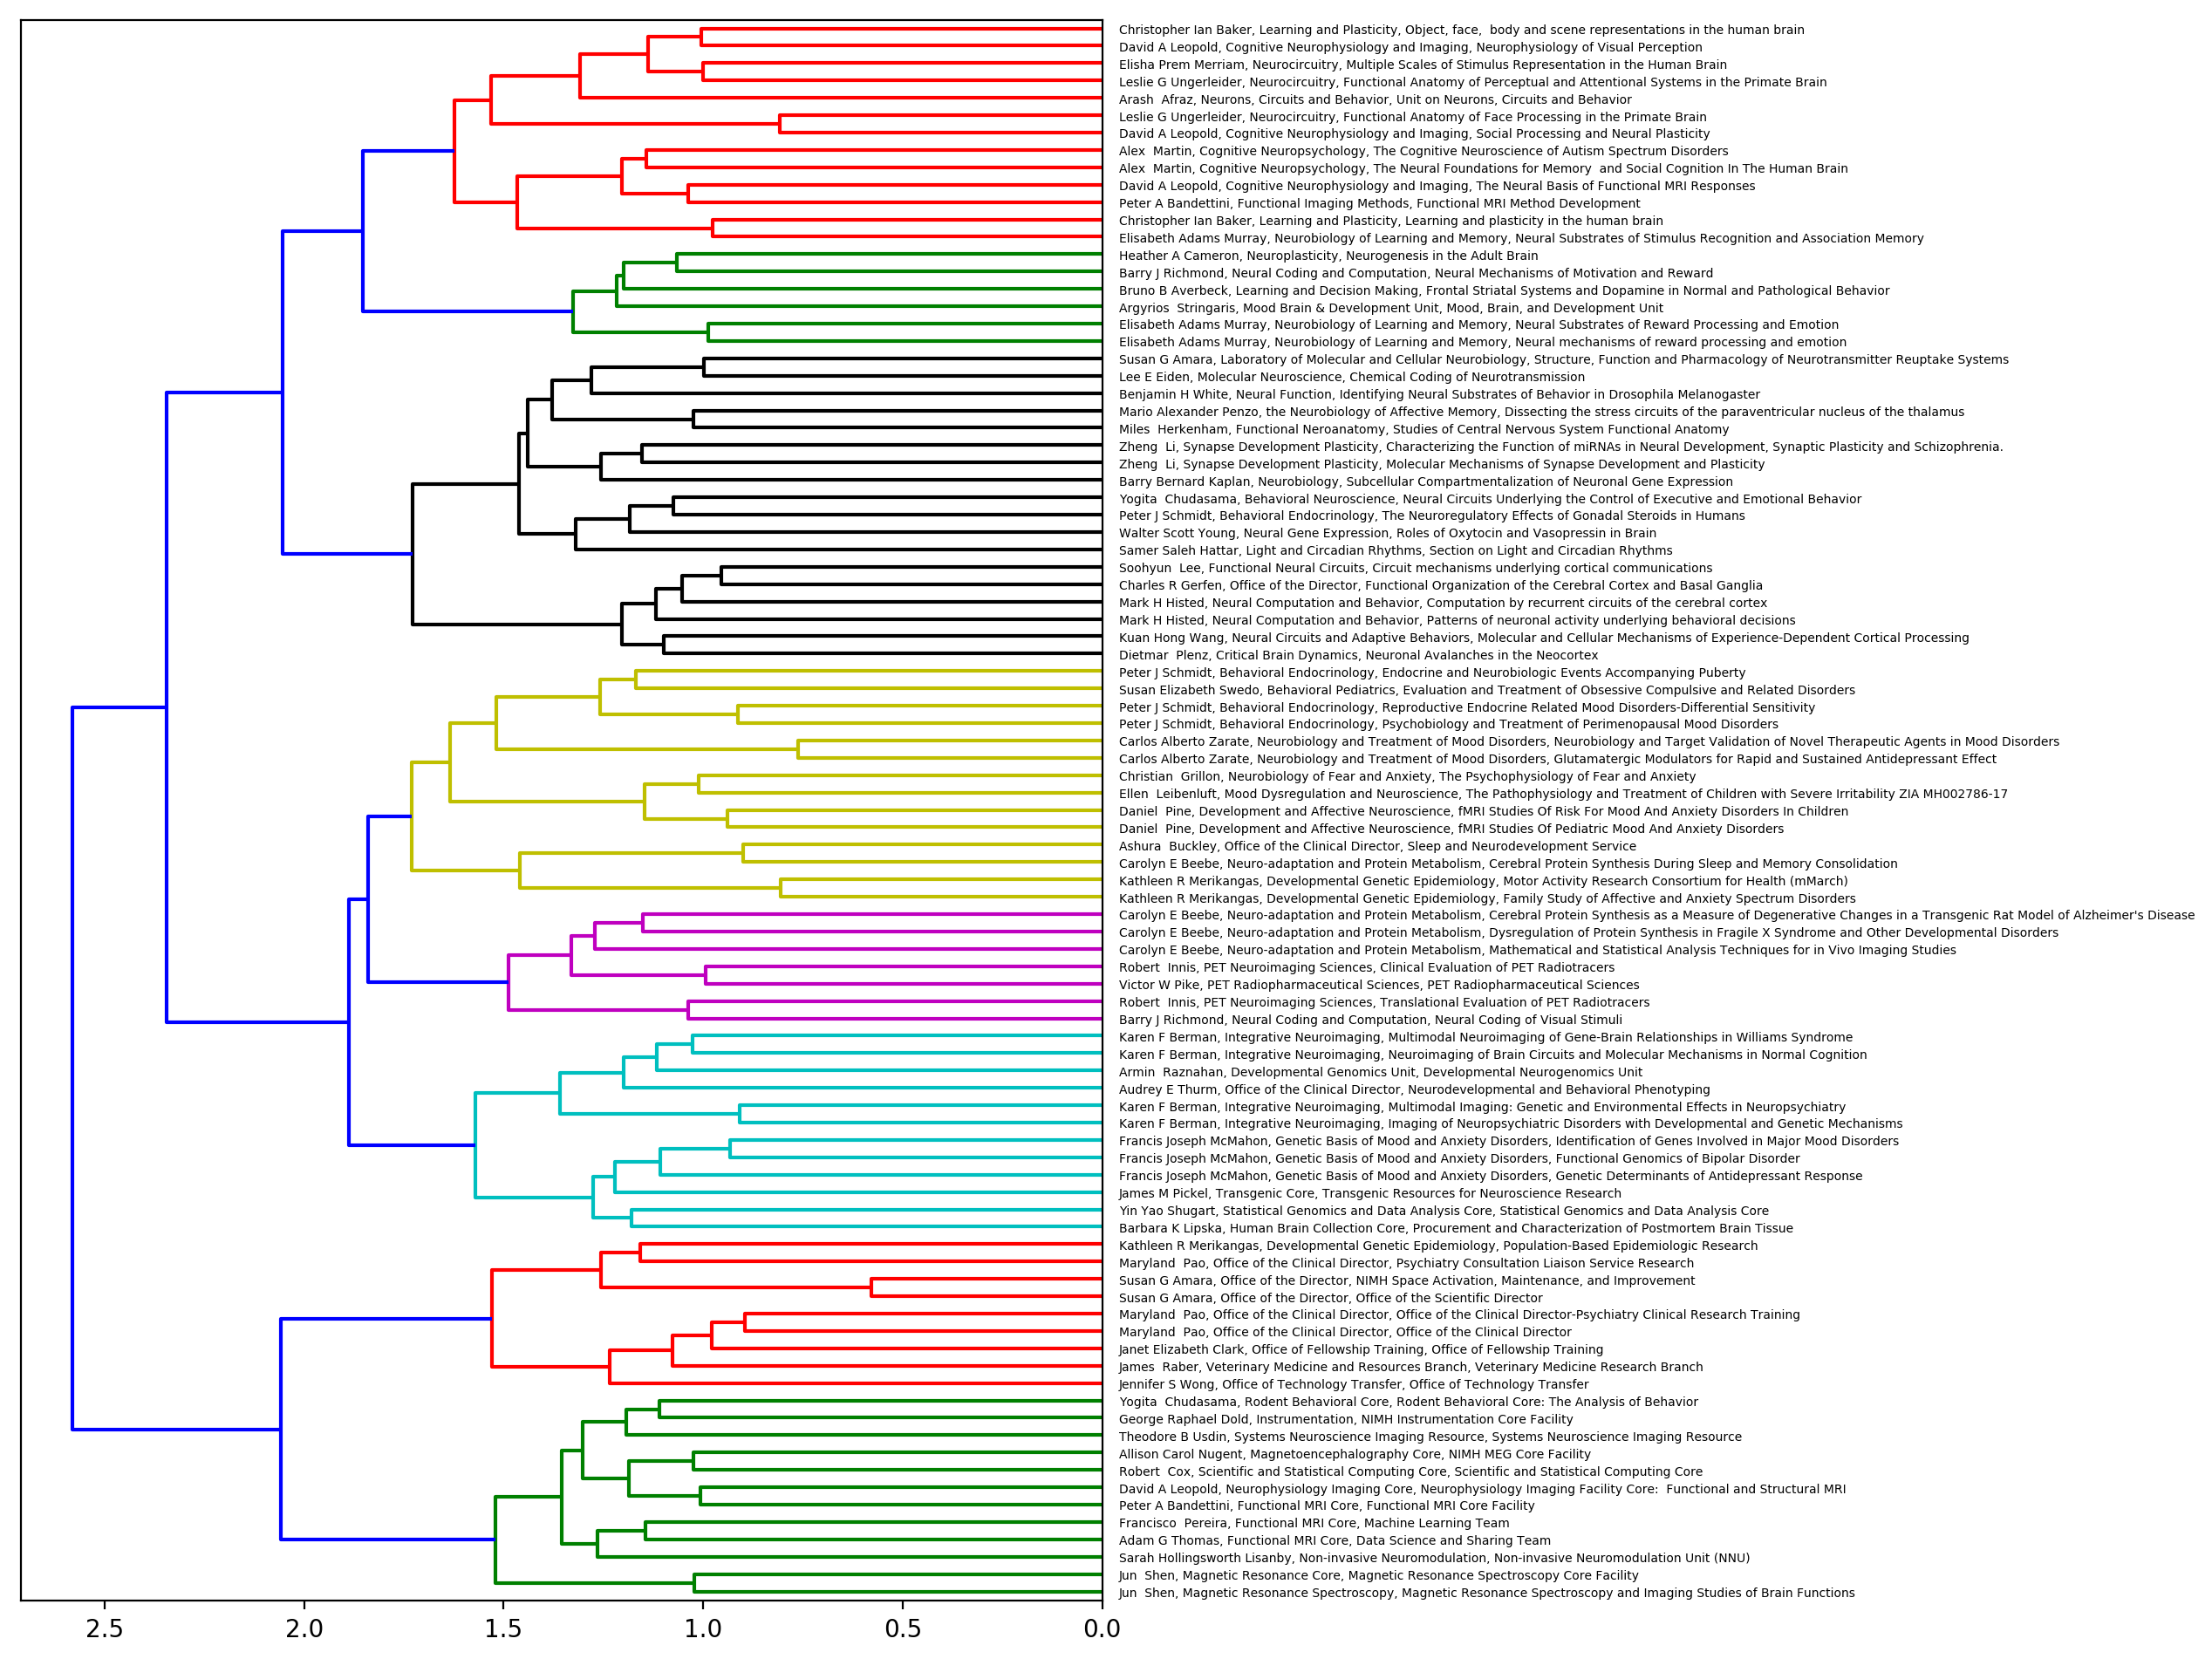

In [73]:
import scipy.cluster.hierarchy as shc
Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(8,12), dpi=200)
dend = shc.dendrogram(Z, labels=pj_df['longlabel'].values, orientation='left', color_threshold=1.8)

In [61]:
pj_df.to_csv('../data/project_df.csv')

In [54]:
len(dend['ivl'])

91

In [40]:
clusters = shc.fcluster(Z, 1.8, criterion='distance')-1

CPU times: user 876 ms, sys: 13.7 ms, total: 889 ms
Wall time: 335 ms


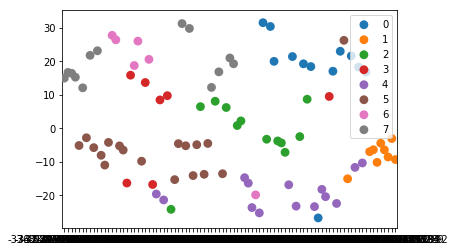

In [44]:
from sklearn.manifold import TSNE
mds = TSNE(perplexity=5, init='pca', learning_rate=10, metric='cosine')
%time pj_mds = mds.fit_transform(tfidf_matrix.toarray())
sns.pointplot(pj_mds[:,0], pj_mds[:,1], hue=clusters, join=False)

In [388]:
pj_df.columns

Index(['2018 Fiscal Year', 'Collaborators from other NIH organizations',
       'Collaborators from other NIMH organizations',
       'Extramural Collaborators', 'Goals and Objectives', 'Keywords',
       'Lab Staff and Collaborators', 'Principal Investigator',
       'Publications Generated', 'Report Title', 'Research Organization',
       'Summary', 'pj_num', 'ipid', 'more_references', 'Lead Investigator',
       'Supervisor of Record', 'PI', 'short_pj_num', 'FY Total Cost by IC',
       'pj_text', 'cluster'],
      dtype='object')

In [45]:
pj_df['cluster'] = clusters

In [49]:
cluster_centers = []
for cl in np.unique(clusters):
    ind = clusters == cl 
    cluster_centers.append(np.median(tfidf_matrix.toarray()[ind,:],0))
cluster_centers = np.array(cluster_centers)

In [55]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = cluster_centers.argsort()[:, ::-1] 

cluster_budgets = pj_df.groupby('cluster')[['FY Total Cost by IC']].sum().values

for i in np.unique(clusters):
    cb = int(cluster_budgets[i][0])
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print(f"Cluster {i:d} total 2017 budget: ${cb:,d}")
    print() #add whitespace
    
    print("Cluster %d Section:" % i, end='')
    for title in pj_df.loc[pj_df['cluster']==i, 'label'].tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print()
print()


Top terms per cluster:

Cluster 0 words: imag, data, research, core, nih, project, softwar, mri, support, method,
Cluster 0 total 2017 budget: $18,635,734

Cluster 0 Section: Jun  Shen, Magnetic Resonance Spectroscopy,
 Sarah Hollingsworth Lisanby, Non-invasive Neuromodulation,
 Peter A Bandettini, Functional MRI Core,
 Robert  Cox, Scientific and Statistical Computing Core,
 Allison Carol Nugent, Magnetoencephalography Core,
 Jun  Shen, Magnetic Resonance Core,
 David A Leopold, Neurophysiology Imaging Core,
 George Raphael Dold, Instrumentation,
 Yogita  Chudasama, Rodent Behavioral Core,
 Adam G Thomas, Functional MRI Core,
 Theodore B Usdin, Systems Neuroscience Imaging Resource,
 Francisco  Pereira, Functional MRI Core,


Cluster 1 words: nimh, research, clinic, nih, irp, program, provid, offic, nation, scientif,
Cluster 1 total 2017 budget: $27,563,168

Cluster 1 Section: Susan G Amara, Office of the Director,
 Maryland  Pao, Office of the Clinical Director,
 Kathleen R Merikanga